In [326]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, cohen_kappa_score
import matplotlib.pyplot as plt




# Data Import

In [ ]:
myData = pd.read_csv("https://www.dropbox.com/s/aohbr6yb9ifmc8w/heart_attack.csv?dl=1")
#data cleaning
myData = myData.dropna()
#myData.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,63,1,3,145,233,0,150,1
1,37,1,2,130,250,1,187,1
2,56,1,1,120,236,1,178,1
3,57,0,0,120,354,1,163,1
4,57,1,0,140,192,1,148,1


In [422]:
myData["sex"] = myData["sex"].astype('category')
myData["cp"] = myData["cp"].astype('category')
myData["restecg"] = myData["restecg"].astype('category')
X = myData.drop(columns="output")
y = myData["output"]

In [423]:
X_no_thalach = X.drop(columns="thalach")
X_no_ecg = X.drop(columns="restecg")
X_no_age = X.drop(columns="age")
X_no_sex = X.drop(columns="sex")
X_no_cp = X.drop(columns="cp")
X_no_trtbps = X.drop(columns="trtbps")
X_no_chol = X.drop(columns="chol")

# Part One: Fitting Models

##### Q1: KNN

In [424]:
datasets = {
    "full": (X),
    "no_thalach": (X_no_thalach),
    "no_ecg": (X_no_ecg),
    "no_age": (X_no_age),
    "no_sex": (X_no_sex),
    "no_cp": (X_no_cp),
    "no_trtbps": (X_no_trtbps),
    "no_chol": (X_no_chol)
}

In [425]:
ct_knn = ColumnTransformer(
    [
        ("dummify", OneHotEncoder(sparse_output=False, handle_unknown='ignore'), make_column_selector(dtype_include=object)),
        ("standardize", StandardScaler(), make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")


In [ ]:
knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier())
    ]
).set_output(transform="pandas")

params = {'knn__n_neighbors': list(range(1, 100))}

for dataset_name, X_data in datasets.items():
    grid_search = GridSearchCV(
        knn_pipeline1,
        params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_data, y)
    
    best_n_neighbors = grid_search.best_params_['knn__n_neighbors']
    best_roc_auc = grid_search.best_score_
    
    print(dataset_name)
    print(f"param {best_n_neighbors}")
    print(f"ROC AUC {best_roc_auc}")
    print()


full
param 65
ROC AUC 0.8125623342175068
no_thalach
param 21
ROC AUC 0.7933846153846155
no_ecg
param 16
ROC AUC 0.8168095490716182
no_age
param 20
ROC AUC 0.8203985853227233
no_sex
param 70
ROC AUC 0.7990167992926615
no_cp
param 17
ROC AUC 0.7646076038903624
no_trtbps
param 19
ROC AUC 0.8188781609195402
no_chol
param 10
ROC AUC 0.8418270557029178


In [427]:
knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier(n_neighbors=10))
    ]
).set_output(transform="pandas")

Confusion Matrix

In [428]:
knn_pipeline1.fit(X_no_chol, y)
y_pred_knn = knn_pipeline1.predict(X_no_chol)
conf_matrix = confusion_matrix(y, y_pred_knn)
class_names = ["not at risk", "at risk"]
conf_matrix_knn = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_knn

,not at risk,at risk
not at risk,102,25
at risk,36,110


While there is no direct access to the knn weights to interpret  I explored the  model with the full dataset, as well as datasets with one predictor missing (tried removing each predictor once). Using my intuition I did not want to remove more than one predictor from the dataset since it seemed they all logically had a place in the model predicting heart attack risk. The best option with a roc auc of 0.8418 was excluding cholesterol with n neighbors of 10. (Was checked from 0-100 neighbors to find the best) 

##### Q2: Logistic Regression

In [ ]:
log_reg_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("log_reg", LogisticRegression())
    ]
).set_output(transform="pandas")

params = {'log_reg__C': [0.01, 0.1, 1, 10, 100]}

for dataset_name, X_data in datasets.items():
    grid_search = GridSearchCV(
        log_reg_pipeline,
        params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_data, y)
    
    best_C = grid_search.best_params_['log_reg__C']
    best_roc_auc = grid_search.best_score_
    
    print(dataset_name)
    print(f"param {best_C}")
    print(f"ROC AUC {best_roc_auc}")
    print()


full
param 10
ROC AUC 0.8543787798408488
no_thalach
param 1
ROC AUC 0.8199511936339523
no_ecg
param 10
ROC AUC 0.8592834659593279
no_age
param 10
ROC AUC 0.8560063660477454
no_sex
param 0.01
ROC AUC 0.7998097259062775
no_cp
param 10
ROC AUC 0.8072212201591512
no_trtbps
param 100
ROC AUC 0.8480671971706455
no_chol
param 1
ROC AUC 0.8557425287356324


In [430]:
log_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("log", LogisticRegression(C=10))
    ]
).set_output(transform="pandas")


Confusion Matrix

In [431]:
log_pipeline.fit(X_no_ecg, y)
y_pred_log = log_pipeline.predict(X_no_ecg)
conf_matrix = confusion_matrix(y, y_pred_log)
class_names = ["not at risk", "at risk"]
conf_matrix_log = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_log

,not at risk,at risk
not at risk,96,31
at risk,24,122


In [432]:
log_pipeline.named_steps['log'].coef_
names = X_no_ecg.columns
coef_df = pd.DataFrame(coefficients.T, index=names)
coef_df

,0
age,-0.244286
sex,-1.012605
cp,0.887842
trtbps,-0.419467
chol,-0.310066
thalach,0.917448


# Finish oceeficient interp!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!


Since we are able to access the log coefficients we can see that (while in log odds format) that sex, thalach, and chest pain are the best predictors in the log model. A one unit increase in sex  I used a similar exploration format as previously testing on the full dataset, as well as datasets with one predictor missing (tried removing each predictor once). I aso followed the same logic not wanting to remove more than one seemingly important variable. The best option with a roc auc of 0.859 was excluding resting ecg with c = 10. (c was grid searched on 0.01, 0.1, 1, 10, 100 to find the best) 

##### Q3: Decision Tree

In [ ]:
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("dt", DecisionTreeClassifier())
    ]
).set_output(transform="pandas")

params = {'dt__min_impurity_decrease': [0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}

for dataset_name, X_data in datasets.items():
    grid_search = GridSearchCV(
        dt_pipeline,
        params,
        cv=5,
        scoring='roc_auc',
        n_jobs=-1
    )
    
    grid_search.fit(X_data, y)
    
    best_min_impurity_decrease = grid_search.best_params_['dt__min_impurity_decrease']
    best_roc_auc = grid_search.best_score_
    
    print(dataset_name)
    print(f"param {best_min_impurity_decrease}")
    print(f"ROC AUC {best_roc_auc}")


full
param 0.01
ROC AUC 0.7673043324491601

no_thalach
param 0.01
ROC AUC 0.7760576480990274

no_ecg
param 0.01
ROC AUC 0.7673043324491601

no_age
param 0.01
ROC AUC 0.7538072502210433

no_sex
param 0.01
ROC AUC 0.7662627763041556

no_cp
param 0.01
ROC AUC 0.728881343943413

no_trtbps
param 0.01
ROC AUC 0.780654288240495

no_chol
param 0.01
ROC AUC 0.7542100795755967



In [434]:
dt_pipeline = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("dt", DecisionTreeClassifier(min_impurity_decrease=0.01))  
    ]
).set_output(transform="pandas")


Confusion Matrix

In [435]:
dt_pipeline.fit(X_no_thalach, y)
y_pred_tree = dt_pipeline.predict(X_no_thalach)
conf_matrix = confusion_matrix(y, y_pred_tree)
class_names = ["not at risk", "at risk"]
conf_matrix_tree = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_tree

,not at risk,at risk
not at risk,98,29
at risk,20,126


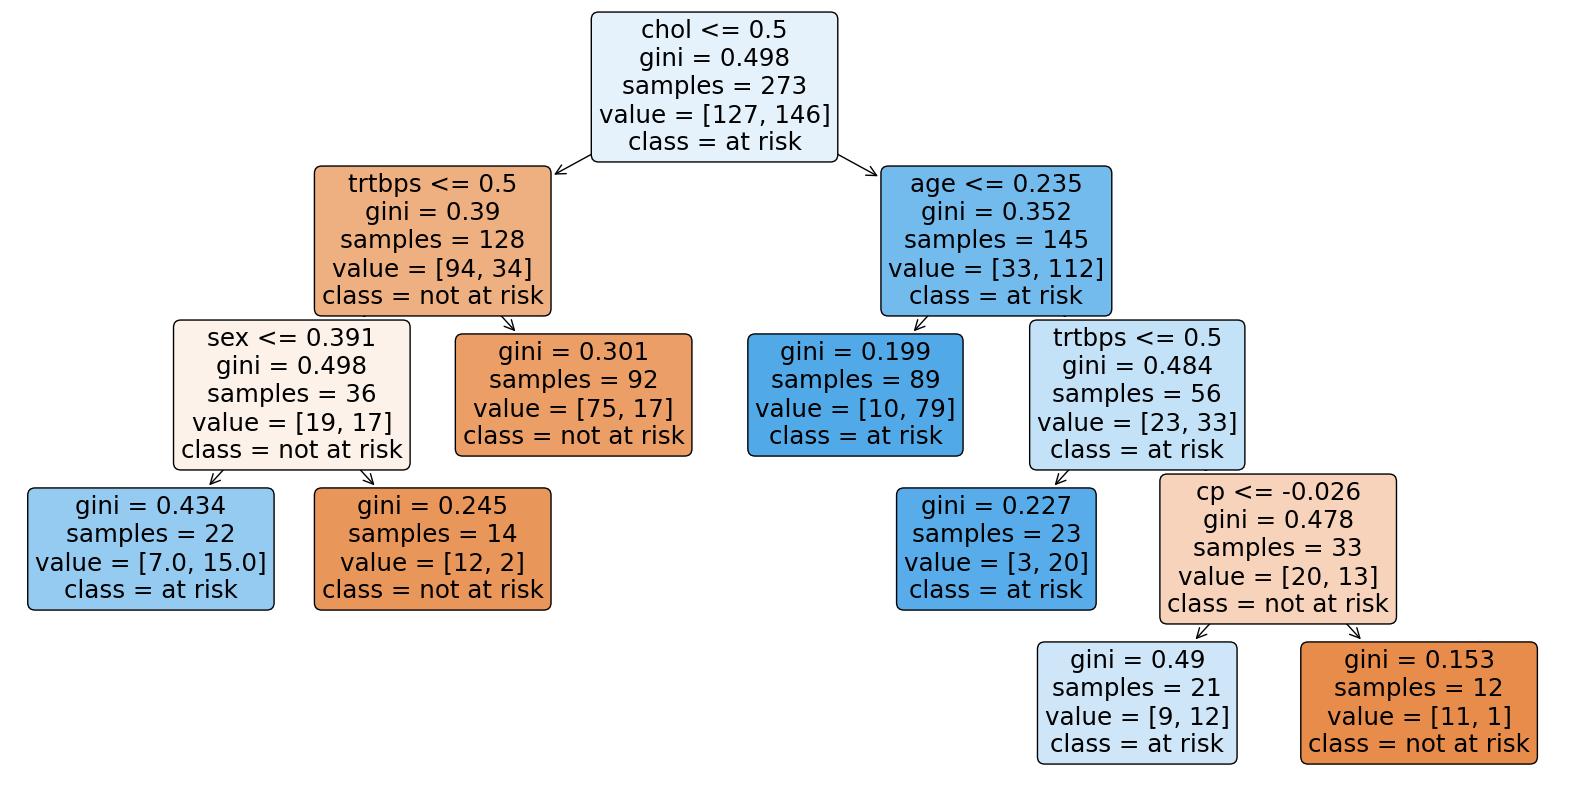

In [498]:
plt.figure(figsize=(20, 10))
plot_tree(dt_pipeline.named_steps['dt'], filled=True, feature_names=X_no_thalach.columns, class_names=['not at risk', 'at risk'], rounded=True)
plt.show()

Looking at the visualization of the decision tree above we can see it favored cholesterol, resting blood pressure, and age as it's top predictors of heart attack risk. I followed the same data logic as before testing on all then moving forward with my final model removing the worst predictor from the dataset. The best option with a roc auc of 0.776 was excluding maximum heart rate with min impurity decrease = .01. (min impurity decrease was grid searched on 0.0, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9 to find the best) 

##### Q4: Interpretation

The predictors that were least important were ecg which was not included in the decision tree and logistic regression as well as cholesterol which was not favored in the knn or logistic regression. Different models tended to favor different predictors with KNN having the most important be chest pain, logistic regression having sex as it's largest coefficient, and the decision tree using cholesterol. That being said the logistic regression had the highest roc auc of .859 followed closely by KNN at .84 and then decision tree significantly lower at 0.776

##### Q5: ROC Curve

##### KNN

In [437]:
fpr, tpr, thresholds = roc_curve(y, y_pred_knn)
roc = pd.DataFrame({'False Positive Rate': fpr,'True Positive Rate': tpr,'Threshold': thresholds})

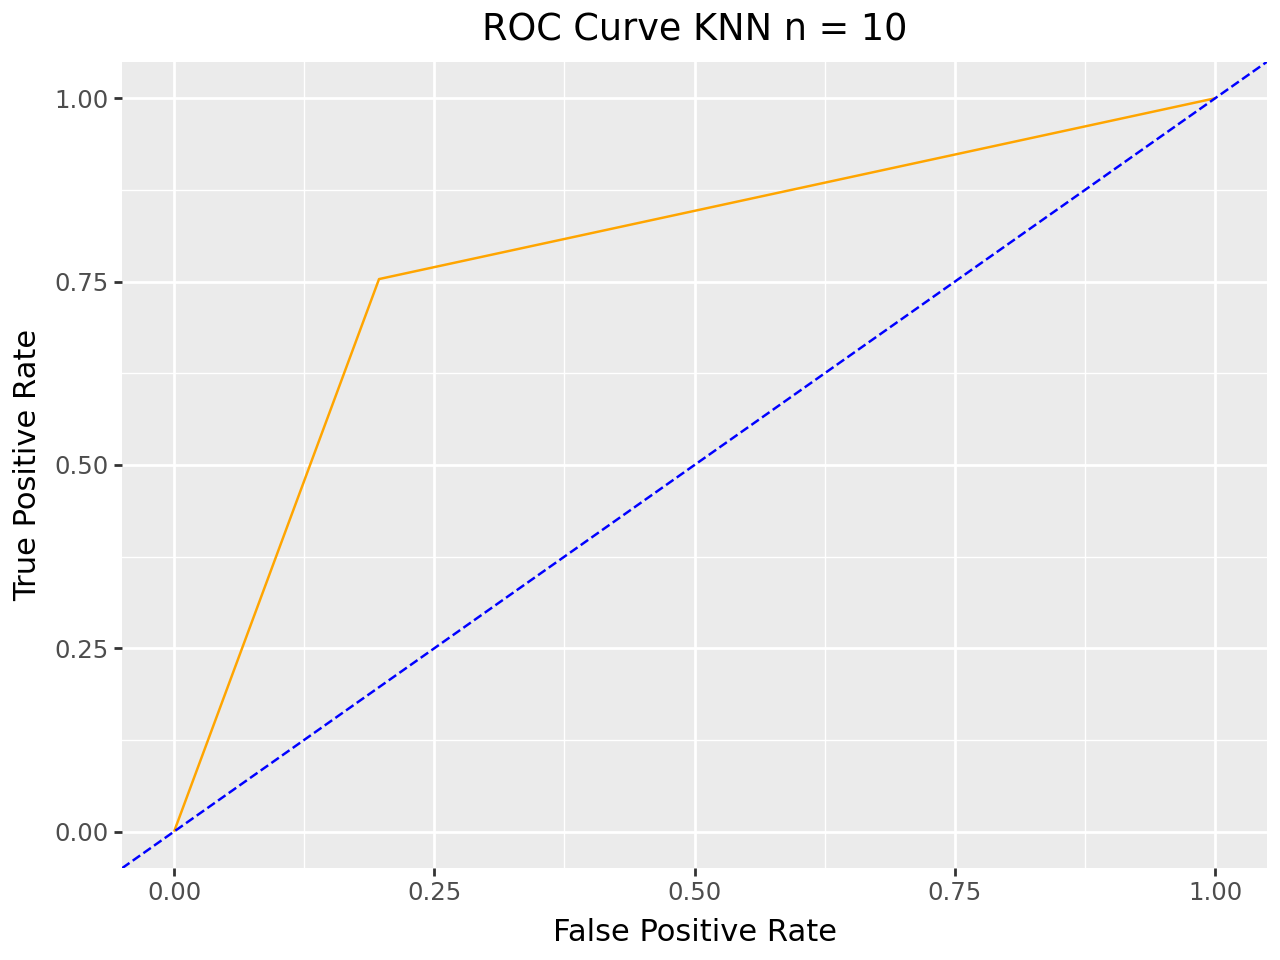

In [438]:
(ggplot(roc, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='orange') +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='blue') +
    labs(
        title='ROC Curve KNN n = 10',
        x='False Positive Rate',
        y='True Positive Rate'
    )
)

##### Logistic Regression

In [439]:
fpr, tpr, thresholds = roc_curve(y, y_pred_log)
roc = pd.DataFrame({'False Positive Rate': fpr,'True Positive Rate': tpr,'Threshold': thresholds})

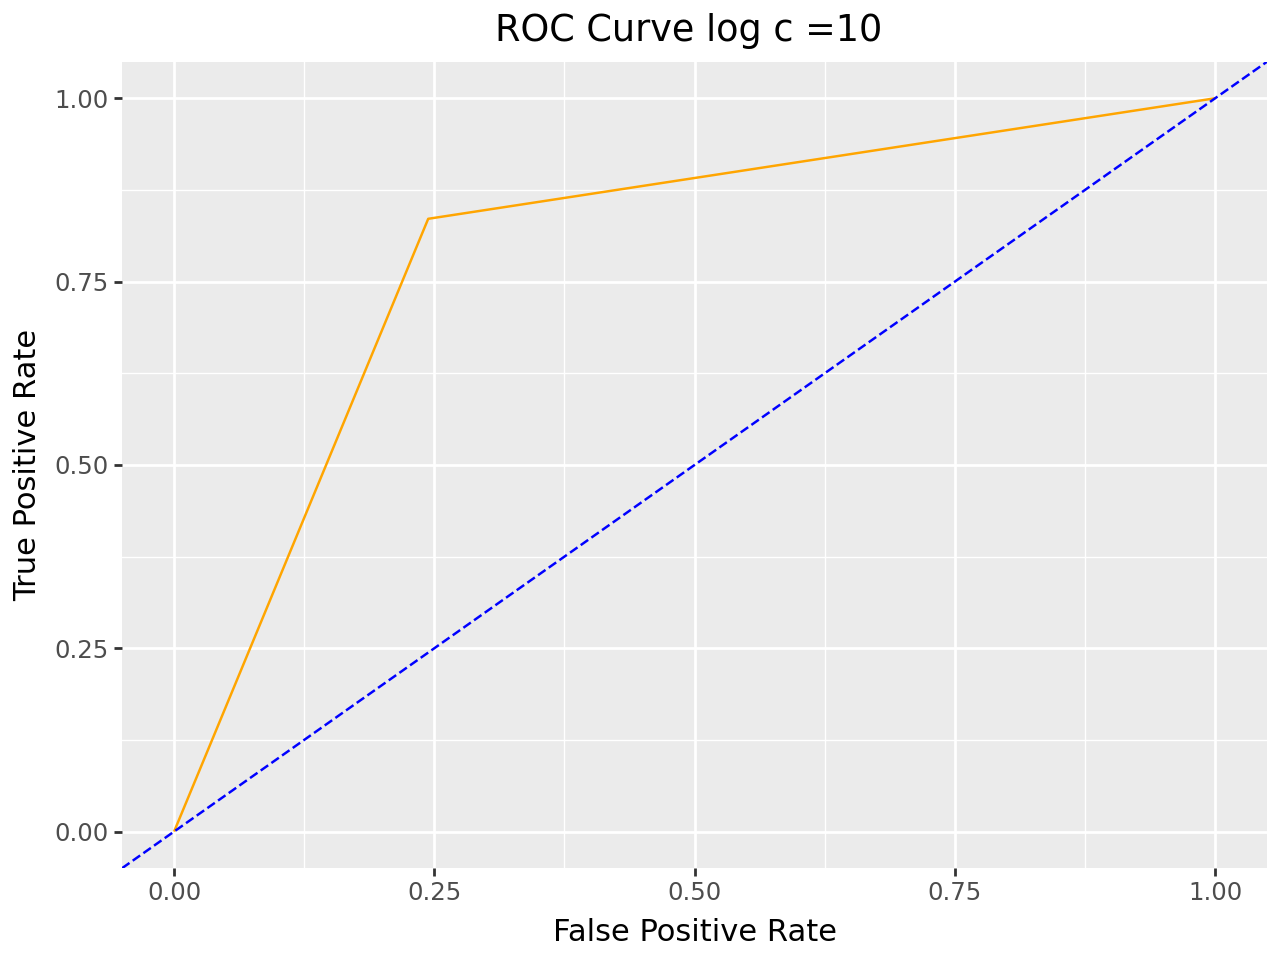

In [440]:
(ggplot(roc, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='orange') +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='blue') +
    labs(
        title='ROC Curve log c =10 ',
        x='False Positive Rate',
        y='True Positive Rate'
    )
)

##### Decision Tree

In [441]:
fpr, tpr, thresholds = roc_curve(y, y_pred_tree)
roc = pd.DataFrame({'False Positive Rate': fpr,'True Positive Rate': tpr,'Threshold': thresholds})

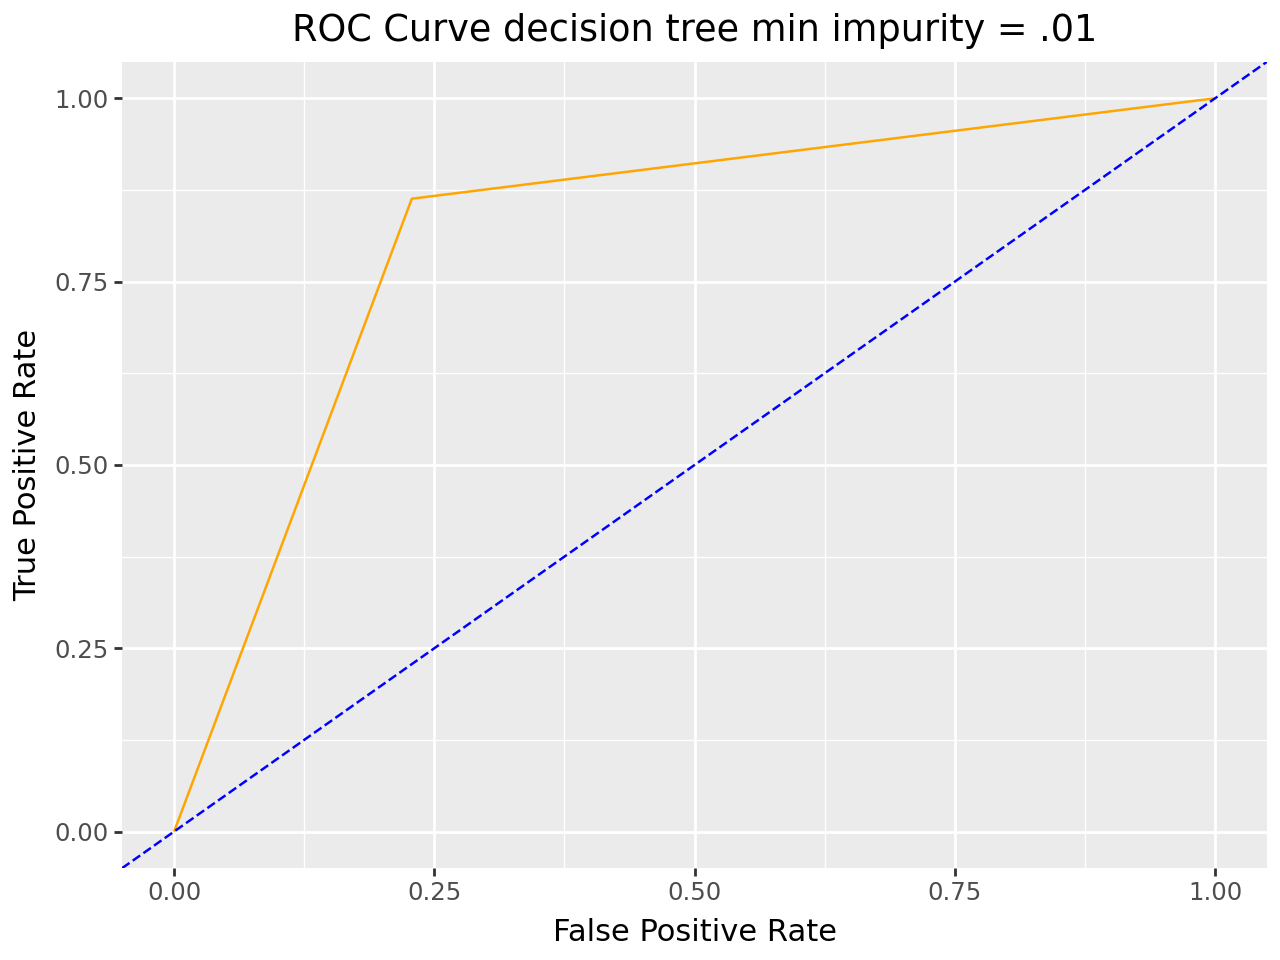

In [442]:
(ggplot(roc, aes(x='False Positive Rate', y='True Positive Rate')) +
    geom_line(color='orange') +
    geom_abline(slope=1, intercept=0, linetype='dashed', color='blue') +
    labs(
        title='ROC Curve decision tree min impurity = .01',
        x='False Positive Rate',
        y='True Positive Rate'
    )
)

# Part Two: Metrics

##### KNN Metrics

Recall

In [443]:
recall1 = recall_score(y, y_pred_knn, average="weighted")
recall1

0.7765567765567766

Precision

In [444]:
precision = precision_score(y, y_pred_knn, average="weighted")
precision

0.7796063303309679

Specificity 

In [445]:
tn = conf_matrix_knn.loc["not at risk", "not at risk"]
fp = conf_matrix_knn.loc["not at risk", "at risk"]
specificity = tn / (tn + fp)
specificity


0.8031496062992126

##### Logistic Regression Metrics

Recall

In [446]:
recall1 = recall_score(y, y_pred_log, average="weighted")
recall1

0.7985347985347986

Precision

In [447]:
precision = precision_score(y, y_pred_log, average="weighted")
precision

0.7986018338959516

Specificity 

In [448]:
tn = conf_matrix_log.loc["not at risk", "not at risk"]
fp = conf_matrix_log.loc["not at risk", "at risk"]
specificity = tn / (tn + fp)
specificity


0.7559055118110236

##### Decision Tree Metrics

Recall

In [449]:
recall1 = recall_score(y, y_pred_tree, average="weighted")
recall1

0.8205128205128205

Precision

In [450]:
precision = precision_score(y, y_pred_tree, average="weighted")
precision

0.821093213329408

Specificity 

In [451]:
tn = conf_matrix_tree.loc["not at risk", "not at risk"]
fp = conf_matrix_tree.loc["not at risk", "at risk"]
specificity = tn / (tn + fp)
specificity


0.7716535433070866

###### combining all metrics together

In [ ]:
recall = [0.776, 0.795, 0.820]
precision = [0.779, 0.798, 0.821]
specificity = [0.803, 0.755, 0.771]
roc_auc = [.841, 0.859, 0.776]


In [478]:
model_names = ["KNN", "log", "tree"]
metrics = pd.DataFrame({
    "ROC AUC": roc_auc,
    "Recall": recall,
    "Precision": precision,
    "Specificity": specificity
}, index=model_names)
metrics

,ROC AUC,Recall,Precision,Specificity
KNN,0.841,0.776,0.779,0.803
log,0.859,0.795,0.798,0.755
tree,0.776,0.820,0.821,0.771


# Part Three: Discussion

##### Q1: The hospital faces severe lawsuits if they deem a patient to be low risk, and that patient later experiences a heart attack

If the hospital faces severe lawsuits if they misclassify a patient they should error on the side of caution when giving someone a low risk diagnosis to limit their liability. In this case their goal should to capture as many high risk heart attack patients as possible (class A) since there is no punishment for classifying someone as high risk when they are not. Recall is the best metric here because it captures how many class A cases were predicted out of total class A cases. The decision tree model is best for this role besting Log, and KNN by .025 and .044 respectively.

##### Q2: The hospital is overfull, and wants to only use bed space for patients most in need of monitoring due to heart attack risk

If the most pressing concern is bedspace then the hospital needs to use the metric that predicts high risk patients most accurately, which is precision. This way they will allocate less bed space to false positives, making sure there is room for people who really need it. The decision tree also pulls ahead in precision with a .821 with the next closest being .798.

##### Q3: The hospital is studying root causes of heart attacks, and would like to understand which biological measures are associated with heart attack risk

Since the hospital is attempting to study the root cause of heart attacks logically they should be using the most accurate model. Similar to question 3 that metric would be precision with the decision tree being the best. Since they are only focused on finding the root cause of heart attacks there isn't a concern of misclassifying people as low risk, or missing high risk patients. 

##### Q4: the hospital is training a new batch of doctors, and they would like to compare the diagnoses of these doctors to the predictions given by the algorithm to measure the ability of new doctors to diagnose patients 

If the hospital is looking to compare their new doctors diagnoses with the algorithm I believe a two metric approach is needed. First precision should be included since you want a doctor that gives accurate predictions, and second specificity because you don't want to be telling people they have a low risk of a heart attack when they are high risk. These two metrics are best since accurate predictions mitigate lawsuit potential, and high precision means high risk patients aren't being misclassified putting their lives at risk.

In [479]:
metrics["Average"] = (metrics["Precision"] + metrics["Specificity"]) / 2
metrics

,ROC AUC,Recall,Precision,Specificity,Average
KNN,0.841,0.776,0.779,0.803,0.7910
log,0.859,0.795,0.798,0.755,0.7765
tree,0.776,0.820,0.821,0.771,0.7960


Looking at the average of precision and specificity for the models (weighted equally) the decision tree comes out ahead at 0.796, and coincidentally also has the best recall. The decision tree is the logical choice to compare doctors diagnoses with.

# Part Four: Validation

In [ ]:
valData = pd.read_csv("https://www.dropbox.com/s/jkwqdiyx6o6oad0/heart_attack_validation.csv?dl=1")
valData = valData.dropna()
Xval = valData.drop(columns="output")
yval = valData["output"]
#valData.head()

,age,sex,cp,trtbps,chol,restecg,thalach,output
0,41,0,1,130,204,0,172,1
1,64,1,3,110,211,0,144,1
2,59,1,0,135,234,1,161,1
3,42,1,0,140,226,1,178,1
4,40,1,3,140,199,1,178,1


In [453]:
X_val_no_thalach = Xval.drop(columns="thalach")
X_val_no_ecg = Xval.drop(columns="restecg")
X_val_no_chol = Xval.drop(columns="chol")

##### KNN Validation

Confusion Matrix

In [454]:
knn_pipeline1.fit(X_no_chol, y)
y_pred_knn2 = knn_pipeline1.predict(X_val_no_chol)
conf_matrix = confusion_matrix(yval, y_pred_knn2)
class_names = ["not at risk", "at risk"]
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_df

,not at risk,at risk
not at risk,9,2
at risk,8,11


ROC AUC

In [455]:
y_predp1 = knn_pipeline1.predict_proba(X_val_no_chol)[:, 1]
roc_auc1 = roc_auc_score(yval, y_predp1, multi_class="ovr", average="weighted")
roc_auc1

0.8708133971291866

Precision

In [456]:
precision = precision_score(yval, y_pred_knn2, average="weighted")
precision

0.7300150829562594

Recall

In [457]:
recall1 = recall_score(yval, y_pred_knn2, average="weighted")
recall1

0.6666666666666666

In [ ]:
recall = [0.666]
precision = [0.730]
roc_auc = [.870]
model_names = ["KNN"]
metrics_knn = pd.DataFrame({
    "ROC AUC": roc_auc,
    "Recall": recall,
    "Precision": precision,
}, index=model_names)
metrics_knn

,ROC AUC,Recall,Precision
tree,0.87,0.666,0.73


In [492]:
knn = metrics.loc[["KNN"]]
knn

,ROC AUC,Recall,Precision,Specificity,Average
KNN,0.841,0.776,0.779,0.803,0.791


When using our validation data the ROC AUC actually improved from 0.841 to 0.87, but recall dropped significantly from 0.776 to 0.666 as did precision going from 0.779 to 0.73. The KNN model became considerably worse when used on new data, especially when looking at recall. Our previous measures of success overestimated the KNN model.

##### Logistic Regression Validation

Confusion Matrix

In [458]:
log_pipeline.fit(X_no_ecg, y)
y_pred_log2 = log_pipeline.predict(X_val_no_ecg)
conf_matrix = confusion_matrix(yval, y_pred_log2)
class_names = ["not at risk", "at risk"]
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_df

,not at risk,at risk
not at risk,9,2
at risk,4,15


ROC AUC

In [459]:
y_predp1 = log_pipeline.predict_proba(X_val_no_ecg)[:, 1]
roc_auc1 = roc_auc_score(yval, y_predp1, multi_class="ovr", average="weighted")
roc_auc1

0.9043062200956937

Precision

In [460]:
precision = precision_score(yval, y_pred_log2, average="weighted")
precision

0.8126696832579186

Recall

In [461]:
recall1 = recall_score(yval, y_pred_log2, average="weighted")
recall1

0.8

In [493]:
recall = [0.8]
precision = [0.812]
roc_auc = [.904]
model_names = ["log"]
metrics_log = pd.DataFrame({
    "ROC AUC": roc_auc,
    "Recall": recall,
    "Precision": precision,
}, index=model_names)
metrics_log


,ROC AUC,Recall,Precision
log,0.904,0.8,0.812


In [488]:
log = metrics.loc[["log"]]
log

,ROC AUC,Recall,Precision,Specificity,Average
log,0.859,0.795,0.798,0.755,0.7765


When using validation data for the log model the ROC AUC improved significantly from .859 to .904, with a slight recall boost from 0.795 to 0.8 similar to precision going from 0.798 to 0.812. The log model performed very well on the new data, increasing roc auc significantly, and getting similar recall and precision. Our previous measures of success underestimated the success of the log model.

##### Decision Tree Validation

Confusion Matrix

In [462]:
dt_pipeline.fit(X_no_thalach, y)
y_pred_tree2 = dt_pipeline.predict(X_val_no_thalach)
conf_matrix = confusion_matrix(yval, y_pred_tree2)
class_names = ["not at risk", "at risk"]
conf_matrix_df = pd.DataFrame(conf_matrix, index=class_names, columns=class_names)
conf_matrix_df

,not at risk,at risk
not at risk,10,1
at risk,5,14


ROC AUC

In [463]:
y_predp1 = dt_pipeline.predict_proba(X_val_no_thalach)[:, 1]
roc_auc1 = roc_auc_score(yval, y_predp1, multi_class="ovr", average="weighted")
roc_auc1

0.8373205741626792

Precision 

In [464]:
precision = precision_score(yval, y_pred_tree2, average="weighted")
precision

0.8355555555555555

Recall

In [465]:
recall1 = recall_score(yval, y_pred_tree2, average="weighted")
recall1

0.8

In [ ]:
recall = [0.8]
precision = [0.835]
roc_auc = [.8373]
model_names = ["tree"]
metrics_tree = pd.DataFrame({
    "ROC AUC": roc_auc,
    "Recall": recall,
    "Precision": precision,
}, index=model_names)
metrics_tree


,ROC AUC,Recall,Precision
tree,0.8373,0.8,0.835


In [489]:
tree = metrics.loc[["tree"]]
tree

,ROC AUC,Recall,Precision,Specificity,Average
tree,0.776,0.82,0.821,0.771,0.796


When using validation data for the decision tree model the ROC AUC improved  from .776 to .8373, with a slight recall decrease from 0.82 to 0.8 and a slight bump in precision going from 0.821 to 0.835. The decision tree model  like the log model performed very well on the new data, increasing roc auc significantly, and getting similar recall and precision. Our previous measures of success slightly underestimated the decision tree model.

# Part Five: Cohen's Kappa

Cohen's kappa is used to compare two raters rating the same thing, and seeing how reliably they do so (after removing the probability of random agreement). This would be useful in a scenario like seeing how the new doctors rate patients heart attack risk compared to each other. This would also be useful in any similar scenario where you have two people rating the same thing ex food critics, car reviewers etc. This is less useful than our past metrics of success for what we are trying to accomplish, because we are comparing the true value of if they have are at high or low risk of heart attack to a predicted value. 

KNN

In [495]:
cohen_kappa_score(y, y_pred_knn)


0.5534550719974258

Logistic Regression

In [496]:
cohen_kappa_score(y, y_pred_log)

0.5936510513923845

Decision Tree

In [497]:
cohen_kappa_score(y, y_pred_tree)

0.6376073470051202

Due to the fact that this is not the intended use of Cohen Kappa I would retain my previous conclusions, for deciding what metric to use in different scenarios. Recall, precision, and specificity provide great indicators for each specific issue. If we did have different data I believe Cohen's Kappa would be useful for the hospital to test new doctors rating similarity though.

#### extra code pls ignore

In [ ]:
ct_knn = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier(n_neighbors=5))
    ]
).set_output(transform="pandas")

In [ ]:
knn_pipeline1.fit(X_train, y_train)
y_pred_proba = knn_pipeline1.predict_proba(X_test)[:, 1]
roc_auc_score(y_test, y_pred_proba)


0.8737373737373738

In [ ]:
knn_pipeline1.fit(X_train, y_train)
y_pred_proba_full = knn_pipeline1.predict_proba(X_test)[:, 1]
roc_auc_full = roc_auc_score(y_test, y_pred_proba_full)
print(roc_auc_full)

knn_pipeline1.fit(X_train_no_thalach, y_train)
y_pred_proba_no_thalach = knn_pipeline1.predict_proba(X_test_no_thalach)[:, 1]
roc_auc_no_thalach = roc_auc_score(y_test, y_pred_proba_no_thalach)
print(roc_auc_no_thalach)

knn_pipeline1.fit(X_train_no_ecg, y_train)
y_pred_proba_no_ecg = knn_pipeline1.predict_proba(X_test_no_ecg)[:, 1]
roc_auc_no_ecg = roc_auc_score(y_test, y_pred_proba_no_ecg)
print(roc_auc_no_ecg)

knn_pipeline1.fit(X_train_no_age, y_train)
y_pred_proba_no_age = knn_pipeline1.predict_proba(X_test_no_age)[:, 1]
roc_auc_no_age = roc_auc_score(y_test, y_pred_proba_no_age)
print(roc_auc_no_age)

knn_pipeline1.fit(X_train_no_sex, y_train)
y_pred_proba_no_sex = knn_pipeline1.predict_proba(X_test_no_sex)[:, 1]
roc_auc_no_sex = roc_auc_score(y_test, y_pred_proba_no_sex)
print(roc_auc_no_sex)

knn_pipeline1.fit(X_train_no_cp, y_train)
y_pred_proba_no_cp = knn_pipeline1.predict_proba(X_test_no_cp)[:, 1]
roc_auc_no_cp = roc_auc_score(y_test, y_pred_proba_no_cp)
print(roc_auc_no_cp)

knn_pipeline1.fit(X_train_no_trtbps, y_train)
y_pred_proba_no_trtbps = knn_pipeline1.predict_proba(X_test_no_trtbps)[:, 1]
roc_auc_no_trtbps = roc_auc_score(y_test, y_pred_proba_no_trtbps)
print(roc_auc_no_trtbps)

knn_pipeline1.fit(X_train_no_chol, y_train)
y_pred_proba_no_chol = knn_pipeline1.predict_proba(X_test_no_chol)[:, 1]
roc_auc_no_chol = roc_auc_score(y_test, y_pred_proba_no_chol)
print(roc_auc_no_chol)


0.8737373737373738
0.8446969696969697
0.8615319865319865
0.8632154882154882
0.7861952861952862
0.819023569023569
0.8838383838383838
0.8842592592592593


In [ ]:
ct_knn = ColumnTransformer(
    [
        ("dummify",
         OneHotEncoder(sparse_output=False, handle_unknown='ignore'),
         make_column_selector(dtype_include=object)),
        ("standardize",
         StandardScaler(),
         make_column_selector(dtype_include=np.number))
    ],
    remainder="passthrough"
).set_output(transform="pandas")

knn_pipeline1 = Pipeline(
    [
        ("preprocessing", ct_knn),
        ("knn", KNeighborsClassifier())
    ]
).set_output(transform="pandas")

param_grid = {
    'knn__n_neighbors': list(range(1, 100))  
}

grid_search = GridSearchCV(
    knn_pipeline1,
    param_grid,
    cv=5,  
    scoring='roc_auc',  
    n_jobs=-1  
)



In [ ]:
grid_search.fit(X_train_no_chol, y_train)
param = grid_search.best_params_['knn__n_neighbors']
score =grid_search.best_score_
print(param,score)

69 0.8452153110047848


In [ ]:
X = myData.drop(columns="output")
y = myData["output"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)
X_train_no_thalach = X_train.drop(columns="thalach")
X_test_no_thalach = X_test.drop(columns="thalach")
X_train_no_ecg = X_train.drop(columns="restecg")
X_test_no_ecg = X_test.drop(columns="restecg")
X_train_no_age = X_train.drop(columns="age")
X_test_no_age = X_test.drop(columns="age")
X_train_no_sex = X_train.drop(columns="sex")
X_test_no_sex = X_test.drop(columns="sex")
X_train_no_cp = X_train.drop(columns="cp")
X_test_no_cp = X_test.drop(columns="cp")
X_train_no_trtbps = X_train.drop(columns="trtbps")
X_test_no_trtbps = X_test.drop(columns="trtbps")
X_train_no_chol = X_train.drop(columns="chol")
X_test_no_chol = X_test.drop(columns="chol")
